**대회 바로가기:** [이미지 분류 해커톤: 데이터 속 아이콘의 종류를 맞혀라!]("https://dacon.io/competitions/official/236459/overview/description")

# Import

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

# Data Load

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# 데이터 수 확인인
print('train num: ', len(train))
print('test num: ', len(test))
train.head()

train num:  769
test num:  250


,ID,label,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,TRAIN_000,building,251,196,51,63,68,78,189,34,...,85,195,63,30,73,65,63,201,251,248
1,TRAIN_001,building,247,184,203,237,255,255,193,255,...,242,239,241,242,242,241,241,241,240,238
2,TRAIN_002,building,217,223,232,231,239,212,109,115,...,96,90,103,166,191,163,190,190,206,231
3,TRAIN_003,cat,133,149,153,138,68,157,159,166,...,245,241,247,255,250,190,186,244,254,201
4,TRAIN_004,building,240,213,187,159,112,134,239,233,...,148,59,163,133,92,196,221,194,182,251


In [4]:
# 총 레이블의 개수수
print(train['label'].nunique())

10


rabbit          128
bird            119
building        108
airplane         95
cat              90
emotion_face     88
apple            51
ball             37
truck            32
police_car       21
Name: label, dtype: int64


C:\Users\sanna\AppData\Local\Temp\ipykernel_20708\3002117102.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


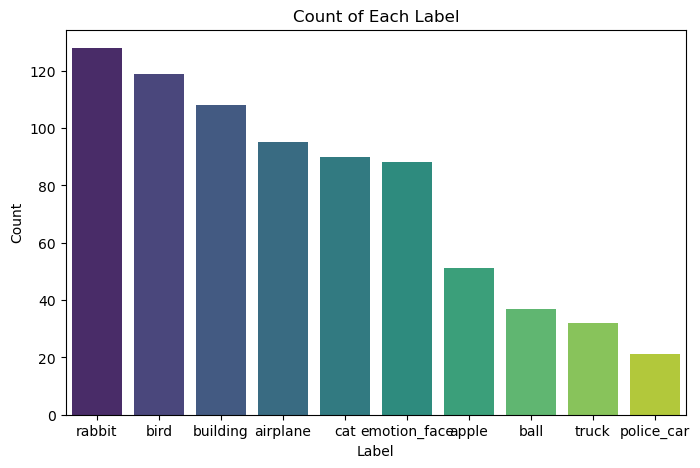

In [6]:
# 라벨별 개수 계산
label_counts = train['label'].value_counts()
print(label_counts)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.show()

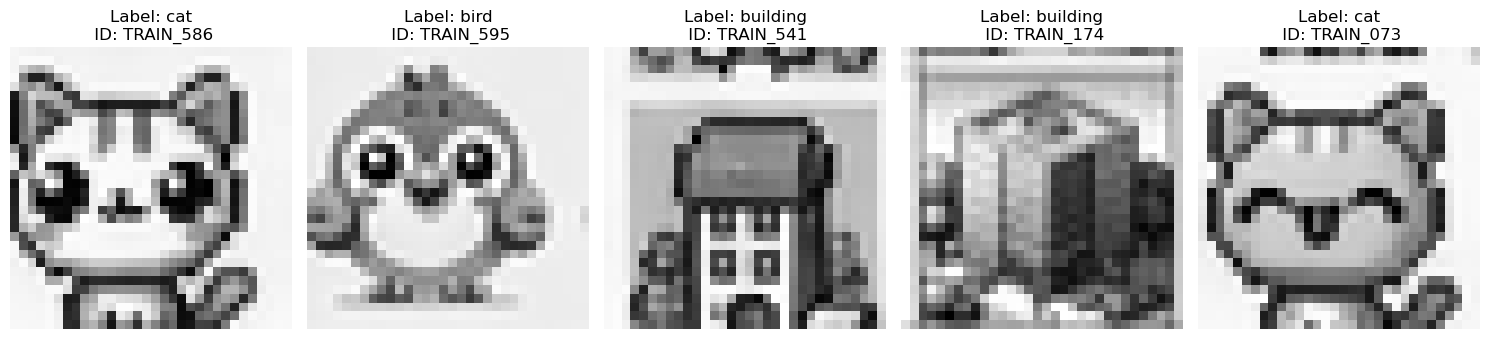

In [7]:
# train 데이터 이미지 시각화
# 랜덤 5개 샘플 선택
random_indices = np.random.choice(len(train), 5, replace=False)
samples = train.iloc[random_indices]

# 시각화
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, (idx, sample) in enumerate(samples.iterrows()):
    image_data = sample.iloc[2:].values.astype(np.uint8).reshape(32, 32)  # 32x32 변환
    axes[i].imshow(image_data, cmap='gray')
    axes[i].set_title(f"Label: {sample['label']}\n ID: {sample['ID']}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

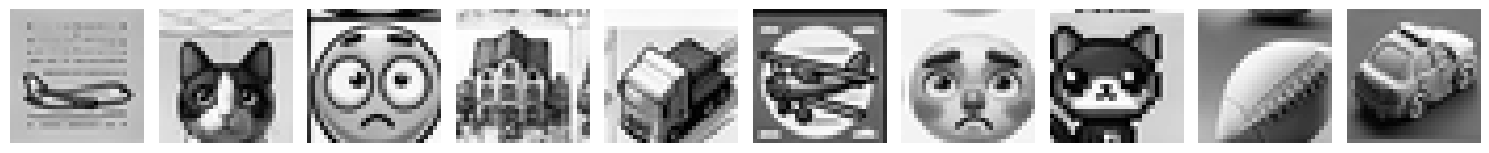

In [8]:
samples = test.head(10)

# 시각화
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for i, (idx, sample) in enumerate(samples.iterrows()):
    image_data = sample.iloc[1:].values.astype(np.uint8).reshape(32, 32)  # 32x32 변환
    axes[i].imshow(image_data, cmap='gray')
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Data Pre-processing

In [9]:
# Feature(X)와 Target(y) 분리
X = train.iloc[:, 2:].values  # 이미지 데이터 (32x32 = 1024 픽셀)
y = train["label"].values     # 분류할 대상 라벨

X_test = test.iloc[:, 1:].values  # 테스트 데이터
print(X.shape)

(769, 1024)


In [10]:
# 라벨을 숫자로 변환 (Label Encoding)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## data augmentaion ver. 1
- `ImageDataGenerator` 사용

In [ ]:
# 데이터 증강 설정
augmentor = ImageDataGenerator(
    rotation_range=20,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True, 
    vertical_flip=True,   
    fill_mode='nearest'       
)

# 증강된 데이터 생성
def augment_images_1(X, y, batch_size=100):
    X = X.reshape(-1, 32, 32, 1)  # 2D 데이터를 4D로 변환 (LightGBM 학습 전에는 다시 2D로 변경 필요)
    generator = augmentor.flow(X, y, batch_size=batch_size)
    augmented_X, augmented_y = next(generator)  
    
    return augmented_X.reshape(augmented_X.shape[0], -1), augmented_y  # 다시 2D로 변환

# 예제: 100개 샘플을 증강
X1_augmented, y1_augmented = augment_images_1(X, y, batch_size=100)

print("Original Shape:", X.shape)  # 원래 2D 데이터
print("Augmented Shape:", X1_augmented.shape)  # 증강 후에도 2D 유지

Original Shape: (769, 1024)
Augmented Shape: (100, 1024)


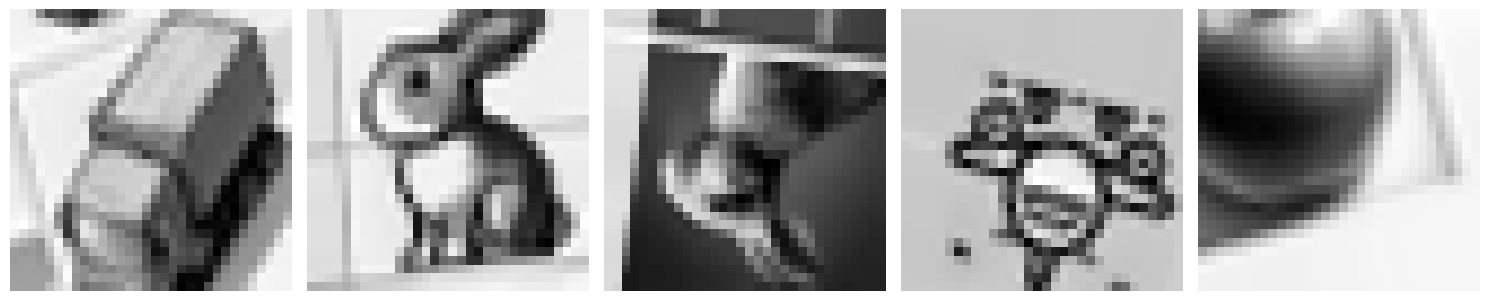

In [ ]:
samples = X1_augmented*255
samples = X1_augmented[:5]
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(samples.shape[0]):  # 100개의 이미지에서 10개를 선택
    image_data = samples[i].reshape(32, 32).astype(np.uint8)  # 32x32로 변환
    axes[i].imshow(image_data, cmap='gray')  # 흑백 이미지로 표시
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## data augmentation ver.2
- `albumentations` 사용

In [ ]:
# 클래스별 증강 설정
augmentation_config = {
    'rabbit': A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomScale(scale_limit=0.1, p=0.5)
    ]),
    'bird': A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomScale(scale_limit=0.1, p=0.5)
    ]),
    'building': A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5)
    ]),
    'airplane': A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomScale(scale_limit=0.08, p=0.5)
    ]),
    'cat': A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomScale(scale_limit=0.1, p=0.5)
    ]),
    'emotion_face': A.Compose([
        A.HorizontalFlip(p=0.5),  # 좌우반전만 적용
        A.Rotate(limit=15, p=0.5)
    ]),
    'apple': A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomScale(scale_limit=0.1, p=0.5)
    ]),
    'ball': A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomScale(scale_limit=0.15, p=0.5)  # 회전 없음, 크기 조정 가능
    ]),
    'truck': A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),  # 회전 각도 제한
        A.RandomScale(scale_limit=0.05, p=0.5)  # 크기 변화 줄이기
    ]),
    'police_car': A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomScale(scale_limit=0.05, p=0.5)  # 트럭과 동일한 설정
    ])
}

# 데이터 증강 수행 함수
def augment_images(image_dict, target_count=100):
    augmented_data = {}

    for label, images in image_dict.items():
        augmented_images = []
        transform = augmentation_config.get(label, None)

        if transform:
            while len(images) + len(augmented_images) < target_count:
                img = random.choice(images)  # 원본 이미지 중 하나를 선택
                augmented = transform(image=img)['image']
                augmented_images.append(augmented)

        augmented_data[label] = images + augmented_images  # 원본 + 증강 데이터 합치기

    return augmented_data


In [ ]:
X2_augmented, y2_augmented = augment_images_2(X, y, batch_size=100)

print("Original Shape:", X.shape)  # 원래 2D 데이터
print("Augmented Shape:", X1_augmented.shape)  # 증강 후에도 2D 유지

In [ ]:
X2_argumented = augment_images_2(train, 'rabbit')

In [ ]:
# 데이터 병합
X_combined = np.concatenate((X, X1_augmented), axis=0)
y_combined = np.concatenate((y, y1_augmented), axis=0)
print(X_combined.shape)
print(y_combined.shape)

(869, 1024)
(869,)


In [53]:
# 데이터 정규화
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)
X_test = scaler.transform(X_test)

# Train1, 일반적으로 train80, valid20으로 분리

- test score: 0.808

In [54]:
# 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

In [55]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)

In [56]:
model_1= LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)

In [57]:
# 모델 학습
model_1.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='multi_logloss'
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178597
[LightGBM] [Info] Number of data points in the train set: 695, number of used features: 1024
[LightGBM] [Info] Start training from score -2.078004
[LightGBM] [Info] Start training from score -2.672711
[LightGBM] [Info] Start training from score -3.017551
[LightGBM] [Info] Start training from score -1.852564
[LightGBM] [Info] Start training from score -1.990035
[LightGBM] [Info] Start training from score -2.137193
[LightGBM] [Info] Start training from score -2.226424
[LightGBM] [Info] Start training from score -3.452869
[LightGBM] [Info] Start training from score -1.807713
[LightGBM] [Info] Start training from score -3.176616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

LGBMClassifier(max_depth=10, random_state=42)

In [58]:
# Validation Set에 대한 예측 및 성능 평가
y_valid_pred = model_1.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print("\nValidation Accuracy:", valid_accuracy)


Validation Accuracy: 0.7816091954022989


# Train2, K-Fold로 교차검증하여 일반화 성능 확인 후 전체 데이터로 학습
- test score: 0.856

In [59]:
model_2 = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)

In [60]:
# K-Fold 교차 검증 사용
y_pred = cross_val_predict(model_2, X_combined, y_combined, cv=5)  # 5-겹 교차 검증

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186320
[LightGBM] [Info] Number of data points in the train set: 695, number of used features: 1024
[LightGBM] [Info] Start training from score -2.078004
[LightGBM] [Info] Start training from score -2.672711
[LightGBM] [Info] Start training from score -3.047404
[LightGBM] [Info] Start training from score -1.852564
[LightGBM] [Info] Start training from score -1.990035
[LightGBM] [Info] Start training from score -2.137193
[LightGBM] [Info] Start training from score -2.213179
[LightGBM] [Info] Start training from score -3.452869
[LightGBM] [Info] Start training from score -1.807713
[LightGBM] [Info] Start training from score -3.176616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [61]:
# 교차 검증 정확도 평가
train_accuracy = accuracy_score(y_combined, y_pred)
print("Train Accuracy from cross-validation:", train_accuracy)

Train Accuracy from cross-validation: 0.7905638665132336


In [62]:
model_2.fit(X_combined, y_combined)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208338
[LightGBM] [Info] Number of data points in the train set: 869, number of used features: 1024
[LightGBM] [Info] Start training from score -2.075995
[LightGBM] [Info] Start training from score -2.672999
[LightGBM] [Info] Start training from score -3.029674
[LightGBM] [Info] Start training from score -1.854688
[LightGBM] [Info] Start training from score -1.988220
[LightGBM] [Info] Start training from score -2.132614
[LightGBM] [Info] Start training from score -2.224048
[LightGBM] [Info] Start training from score -3.471506
[LightGBM] [Info] Start training from score -1.804498
[LightGBM] [Info] Start training from score -3.183824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

LGBMClassifier(max_depth=10, random_state=42)

# Train3, augmentation을 안 한 좋은 데이터로만 훈련시키면?

In [63]:
model_3 = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)

In [64]:
# K-Fold 교차 검증 사용
y_pred = cross_val_predict(model_3, X, y, cv=5)  # 5-겹 교차 검증

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134772
[LightGBM] [Info] Number of data points in the train set: 615, number of used features: 1024
[LightGBM] [Info] Start training from score -2.090889
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -3.054326
[LightGBM] [Info] Start training from score -1.867745
[LightGBM] [Info] Start training from score -1.967275
[LightGBM] [Info] Start training from score -2.144956
[LightGBM] [Info] Start training from score -2.173127
[LightGBM] [Info] Start training from score -3.588409
[LightGBM] [Info] Start training from score -1.786893
[LightGBM] [Info] Start training from score -3.163526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [65]:
# 교차 검증 정확도 평가
train_accuracy = accuracy_score(y, y_pred)
print("Train Accuracy from cross-validation:", train_accuracy)

Train Accuracy from cross-validation: 0.8309492847854356


In [66]:
model_3.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155615
[LightGBM] [Info] Number of data points in the train set: 769, number of used features: 1024
[LightGBM] [Info] Start training from score -2.091214
[LightGBM] [Info] Start training from score -2.713265
[LightGBM] [Info] Start training from score -3.034173
[LightGBM] [Info] Start training from score -1.865967
[LightGBM] [Info] Start training from score -1.962960
[LightGBM] [Info] Start training from score -2.145281
[LightGBM] [Info] Start training from score -2.167754
[LightGBM] [Info] Start training from score -3.600569
[LightGBM] [Info] Start training from score -1.793061
[LightGBM] [Info] Start training from score -3.179355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

LGBMClassifier(max_depth=10, random_state=42)

# Prediction

In [67]:
y1_pred = model_1.predict(X_test)

# 예측된 값을 원래 라벨로 변환
y1_pred_labels = label_encoder.inverse_transform(y1_pred)

In [68]:
y2_pred = model_2.predict(X_test)

# 예측된 값을 원래 라벨로 변환
y2_pred_labels = label_encoder.inverse_transform(y2_pred)

In [69]:
y3_pred = model_3.predict(X_test)

# 예측된 값을 원래 라벨로 변환
y3_pred_labels = label_encoder.inverse_transform(y3_pred)

# Submission

In [70]:
submission = pd.read_csv('sample_submission.csv')

submission['label'] = y1_pred_labels
submission.to_csv('./model1_submission.csv', index = False, encoding = 'utf-8-sig')

In [71]:
submission['label'] = y2_pred_labels
submission.to_csv('./model2_submission.csv', index = False, encoding = 'utf-8-sig')

In [72]:
submission['label'] = y3_pred_labels
submission.to_csv('./model3_submission.csv', index = False, encoding = 'utf-8-sig')